# NLP for filtering Spam SMS

In [1]:
import pandas as pd

In [2]:
messages = pd.read_csv("smsspamcollection/SMSSpamCollection", 
                       sep ="\t", names = ["label", "message"])

In [3]:
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# Exploratory Data Analysis

In [4]:
messages.groupby("label").describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

Let's do some feature engineering and make a new column to detect how long the text message is'

In [5]:
messages["length"] = messages["message"].apply(len)

In [6]:
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


# Data visualization

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

C:\anaconda\envs\DataSciense\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


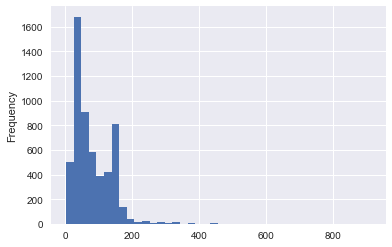

In [8]:
messages["length"].plot(bins = 40, kind = "hist")

In [9]:
messages.length.describe()

count    5572.000000
mean       80.489950
std        59.942907
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

910 characters!!! I need to see this message

In [10]:
messages[messages["length"]==910]["message"].iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000EF85B0B3C8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000000EF85B61D30>], dtype=object)

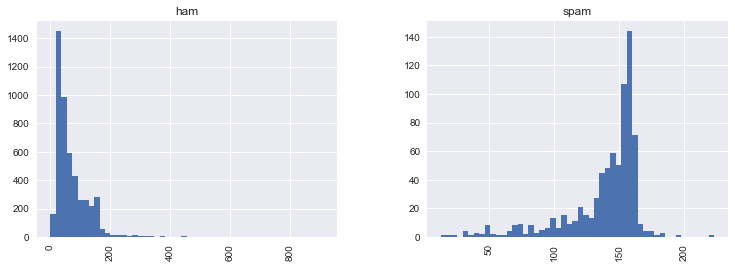

In [11]:
messages.hist(column = "length", by = "label", bins = 50, figsize = (12, 4))

It seems that chances that a message is spam are bigger when the string length is longer

# Text pre-processing

First step will be writting a function that will split a message into its individual words and return a list. I will also remove very common words ("the", "a", etc...). For this,  will use NLTK library.

In [12]:
import string
from nltk.corpus import stopwords

In [13]:
stopwords.words("english")[0:10]#explore some stopwords

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your']

In [14]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [15]:
def text_process(mess):
    #Check characters to see if there are punctuation
    nopunc = [char for char in mess if char not in string.punctuation]
    
    #Join the characters again
    nopunc = "".join(nopunc)
    
    #Remove stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words ("english")]

Now, I need to tokenize the terms. We are creating "lemmas".

In [16]:
messages["message"].head(5).apply(text_process)

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, dont, think, goes, usf, lives, around, t...
Name: message, dtype: object

# Vectorization

Now, that we already have lemmas, we need to convert each of those messages into a vector to work with. It is donde in 3 steps:

1.Term frequency. Which is counting how many times a word ocurr in each message.
2.Inverse Term frequency. Weight the count, so that frequent tokens get lower weight. Contrary to what intuation might suggest, most frequent words ("I", "a",...) are the less important giving meaning to the string.
3. Normalize the vectors to unit length, to abstract from the originanl text.

Let's begin!

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

In [18]:
bow_transformer = CountVectorizer(analyzer = text_process).fit(messages["message"])

#Print total number of vocab words
print(len(bow_transformer.vocabulary_))

11425


Let's take on text message and get its bag-of-words counts as a vector, putting to use our new `bow_transformer`

In [19]:
message4 = messages["message"][3]
print(message4)

U dun say so early hor... U c already then say...


Now, its vector representation

In [20]:
bow4 = bow_transformer.transform([message4])
print(bow4)
print(bow4.shape)

  (0, 4068)	2
  (0, 4629)	1
  (0, 5261)	1
  (0, 6204)	1
  (0, 6222)	1
  (0, 7186)	1
  (0, 9554)	2
(1, 11425)


this means, there are 7 unqiue words in this message after removing stop words. Two of them appear twice and the rest just once.
Let's generalize!

In [21]:
messages_bow = bow_transformer.transform(messages["message"])

In [22]:
print("Shape of Sparse matrix: ", messages_bow.shape)
print("Amount of Non-Zero ocurrences ", messages_bow.nnz) 

Shape of Sparse matrix:  (5572, 11425)
Amount of Non-Zero ocurrences  50548


In [24]:
sparsity = (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1]))
print("sparsity {}".format(round(sparsity)))

sparsity 0


After counting normalization can be done with TF-IDF (Term Frequency- Inverse document frequency)

In [25]:
from sklearn.feature_extraction.text import TfidfTransformer

In [27]:
tfid_transformer = TfidfTransformer().fit(messages_bow)

In [28]:
print(tfid_transformer.idf_[bow_transformer.vocabulary_["u"]]) #check word "u" frequency
print(tfid_transformer.idf_[bow_transformer.vocabulary_["university"]]) #check word "university" frequency

3.28005242674
8.5270764989


transforming, now, the entire bag of words...

In [29]:
messages_tfidf = tfid_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(5572, 11425)


# Training a model

I am going to use Naive Bayes classifier algorithm. It seems to me that it is a good choice as at the end we need a good way to compute chances (probability), of classifying as spam | ham.

In [30]:
from sklearn.naive_bayes import MultinomialNB

In [31]:
spam_detect_model = MultinomialNB().fit(messages_tfidf, messages["label"])

# Model Evaluation

In [32]:
all_predictions = spam_detect_model.predict(messages_tfidf)
print(all_predictions)

['ham' 'ham' 'spam' ..., 'ham' 'ham' 'ham']


In [33]:
from sklearn.metrics import classification_report

In [34]:
print (classification_report(messages["label"], all_predictions))

             precision    recall  f1-score   support

        ham       0.98      1.00      0.99      4825
       spam       1.00      0.85      0.92       747

avg / total       0.98      0.98      0.98      5572



Not bad! but as I did not train/test the model, it is not clear if it is overfitted and the model just learn its way or for the contrary, we have a pretty good model to predict ham/Spam. Because of that I am going to repeat the model

# Train Test split

In [35]:
from sklearn.model_selection import train_test_split

In [36]:
msg_train, msg_test, label_train, label_test = train_test_split(messages["message"], 
                                                               messages["label"], test_size = 0.3)

In [37]:
print(len(msg_train), len(msg_test), len(msg_train) + len(msg_test) )

3900 1672 5572


# Create a pipeline

In [38]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [39]:
pipeline.fit(msg_train,label_train)

Pipeline(steps=[('bow', CountVectorizer(analyzer=<function text_process at 0x000000EF87B76F28>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocesso...f=False, use_idf=True)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [40]:
predictions = pipeline.predict(msg_test)

In [41]:
print(classification_report(predictions,label_test))

             precision    recall  f1-score   support

        ham       1.00      0.96      0.98      1527
       spam       0.71      1.00      0.83       145

avg / total       0.98      0.97      0.97      1672



Done!